# Import libraries

First we import the libraries to use them later

In [2]:
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.2 MB/s eta 0:00:00


In [3]:
import os
import cv2
import time
import math
import glob
import seaborn
import visualkeras
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from PIL import ImageFont
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report

# Download and create dataset

in this section we download the dataset from:<br> https://figshare.com/articles/dataset/GRAZPEDWRI-DX/14825193

In [4]:
# Download the first file #
import gdown

output_file = 'dataset.csv'
gdown.download('https://figshare.com/ndownloader/files/35026432', output_file, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/35026432
To: /content/dataset.csv
100%|██████████| 1.85M/1.85M [00:01<00:00, 1.70MB/s]


'dataset.csv'

In [5]:
# Download the second file #
output_file = 'folder_structure.zip'
gdown.download('https://figshare.com/ndownloader/files/34268819', output_file, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/34268819
To: /content/folder_structure.zip
100%|██████████| 26.3M/26.3M [00:02<00:00, 9.46MB/s]


'folder_structure.zip'

In [6]:
# Download the third file #
output_file = 'images_part1.zip'
gdown.download('https://figshare.com/ndownloader/files/34268828', output_file, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/34268828
To: /content/images_part1.zip
100%|██████████| 4.05G/4.05G [04:06<00:00, 16.4MB/s]


'images_part1.zip'

In [7]:
# Download the fourth file #
output_file = 'images_part2.zip'
gdown.download('https://figshare.com/ndownloader/files/34268849', output_file, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/34268849
To: /content/images_part2.zip
100%|██████████| 4.12G/4.12G [04:12<00:00, 16.3MB/s]


'images_part2.zip'

In [8]:
# Download the fifth file #
output_file = 'images_part3.zip'
gdown.download('https://figshare.com/ndownloader/files/34268864', output_file, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/34268864
To: /content/images_part3.zip
100%|██████████| 3.85G/3.85G [03:55<00:00, 16.4MB/s]


'images_part3.zip'

In [9]:
# Download the sixth file #
output_file = 'images_part4.zip'
gdown.download('https://figshare.com/ndownloader/files/34268891', output_file, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/34268891
To: /content/images_part4.zip
100%|██████████| 4.21G/4.21G [04:17<00:00, 16.4MB/s]


'images_part4.zip'

in the next step, we extract all the images

In [11]:
# Your code here #
!unzip images_part1.zip -d dataset
!unzip images_part2.zip -d dataset
!unzip images_part3.zip -d dataset
!unzip images_part4.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/4584_1095189599_01_WRI-R2_M007.png  
 extracting: dataset/4584_1151264641_02_WRI-R1_M009.png  
  inflating: dataset/4584_1151264682_02_WRI-R2_M009.png  
 extracting: dataset/4585_0910481351_01_WRI-R1_F015.png  
  inflating: dataset/4585_0910481388_01_WRI-R2_F015.png  
  inflating: dataset/4586_0884855982_01_WRI-L1_F015.png  
  inflating: dataset/4586_0884856014_02_WRI-L2_F015.png  
 extracting: dataset/4587_0374311741_01_WRI-L1_M010.png  
  inflating: dataset/4587_0374311805_01_WRI-L2_M010.png  
 extracting: dataset/4587_0374883247_02_WRI-L1_M010.png  
 extracting: dataset/4587_0374883292_02_WRI-L2_M010.png  
 extracting: dataset/4587_0376004535_03_WRI-L1_M010.png  
 extracting: dataset/4587_0376004566_03_WRI-L2_M010.png  
 extracting: dataset/4588_1034162079_01_WRI-L1_F000.png  
 extracting: dataset/4588_1034162125_01_WRI-L2_F000.png  
 extracting: dataset/4589_0422543585_01_WRI-R1_F012.png  
 extracting: dataset/

Next, due to disk limitations, we delete all zip files

In [13]:
# Your code here #
os.remove('images_part1.zip')
os.remove('images_part2.zip')
os.remove('images_part3.zip')
os.remove('images_part4.zip')

# Read csv file

In the csv file, we only need the filestem and fracture_visible columns. Here is a description of them:

*   <b>filestem:<br> </b> the name of images (note that we should add 'png' to them)
*   <b>fracture_visible: </b> <br> image labels (note that the labels are binary and we replace 'Nan' values with '0') <br>
---
As it is clear from the csv file, we have 20327 photos







In [14]:
# Your code here #
df = pd.read_csv("dataset.csv")

df = df[["filestem", "fracture_visible"]]

df["fracture_visible"] = df["fracture_visible"].fillna(0)
df["filestem"] = df["filestem"] + '.png'

df.to_csv("data.csv", index=False)

# Create dataloader

Our images are grayscale so we convert them to RGB becase the models input must have three channels.<br> Then we resize the images to (224,224,3) becuase all input images must be the same size.

In [39]:
size = 224
image_dir = 'dataset/'
idx = 0
# for f in df['filestem']:
#     if f[-3:] == 'jpg' or f[-3:] == 'png':
#         # Your code here #
image_files = [os.path.join(image_dir, f) for f in df['filestem'] if f[-3:] in ['jpg', 'png']]

df_images = pd.DataFrame({'file_path': image_files, 'fracture_visible': df['fracture_visible']})


Due to RAM limitations, we should use dataloader and batch size.<br> Here is some information about data after the dataloader is created:

*   <b> Image shape: </b> (224, 224, 3)
*   <b> Number of channels: </b> 3
*   <b> Channel format: </b> RGB
*   <b> Data scale: </b> 0 to 1
*   <b> Batch size: </b> 64
*   <b> Validation size: </b> 20%
*   <b> Data type: </b> float32








In [19]:
# Convert "fracture_visible" column values to strings
df_images["fracture_visible"] = df_images["fracture_visible"].astype(str)

In [20]:
# Your code here #
# Split the data into training and validation sets
train_df, val_df = train_test_split(df_images, test_size=0.2, random_state=42)

batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='fracture_visible',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='fracture_visible',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='binary'
)

# Get information about the data
image_shape = train_generator.image_shape
num_channels = image_shape[2]
data_scale = f"0 to 1 (float32)"
batch_size = train_generator.batch_size

Found 16261 validated image filenames belonging to 2 classes.
Found 4066 validated image filenames belonging to 2 classes.


In [21]:
train_size = train_generator.samples
validation_size = val_generator.samples

# plot some images

In this section we show some images and their labels with matplotlib library

In [22]:
def visualize(data,figsize,shape):
    '''
      visualize some samples
      input(s):
        data (int): The dataset we want to show some examples of
        figsize (tuple): size of images for display
        shape (tuple): number of images for display
      output(s):
        visualize some samples
    '''

    # obtain one batch of training images
    dataiter = iter(data)
    images, labels = next(dataiter)

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=figsize)
    x,y = shape
    for idx in np.arange(x*y):
        ax = fig.add_subplot(x, y, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        ax.set_title(str(labels[idx].argmax()))

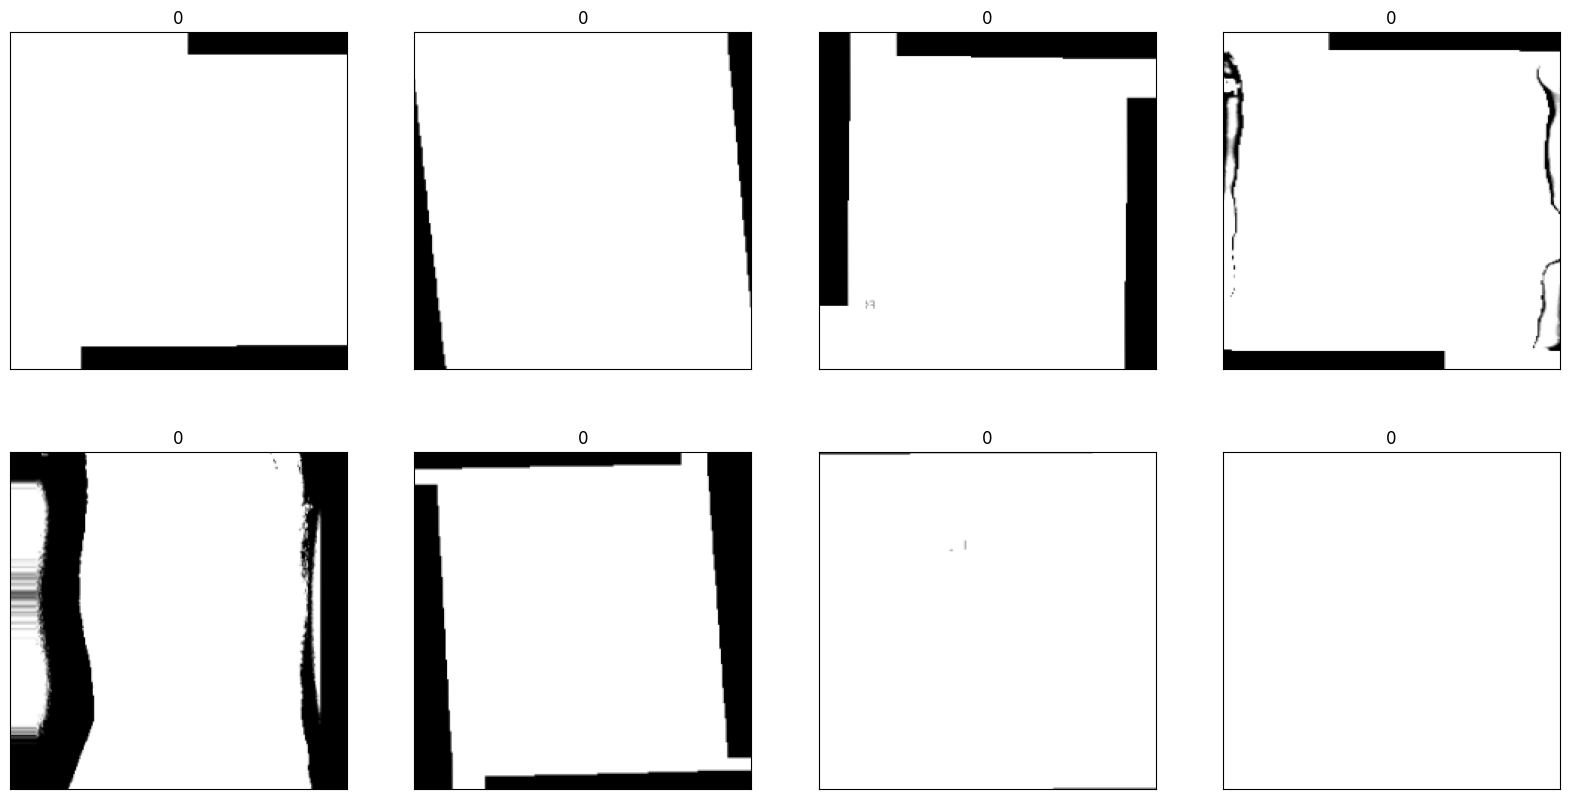

In [23]:
visualize(train_generator,(20,10),(2,4))

# Define models

We use transfer learning with imagenet weights for training our models.<br> We fine tune the last two layers and use a multi layer perceptron(MLP) with a hidden layer of size 128 and two neurons in the last layer for prediction. <br> Also we use Categorical CrossEntropy as the loss function and Adam as the optimizer. <br> 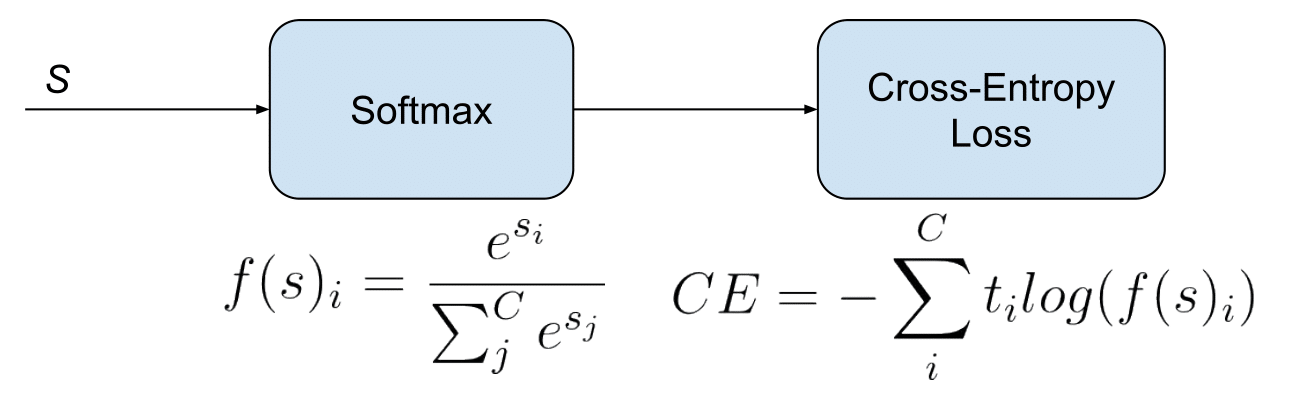

in this section we define a function that takes `conv_model` as input and we want to fine-tune our model.

Note: please tune the last two layers of the conv model and then create a mlp with 128 hidden layer and `relu` function for activation.

In [40]:
def define_model(conv_model):
    # Your code here #
    for layer in conv_model.layers[:-2]:
        layer.trainable = False

    # Add a global average pooling layer
    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)

    # Add a fully connected layer with 128 neurons and ReLU activation
    x = keras.layers.Dense(128, activation='relu')(x)

    # Add the output layer with two neurons for binary classification
    predictions = keras.layers.Dense(1, activation='softmax')(x)

    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    full_model.summary()
    full_model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'],)
    return full_model

# Training

# Define fnctions for plots

In [63]:
def loss_plot(model_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(model_history.history['loss']);
    plt.title('Training Loss');
    plt.subplot(1,2,2)
    plt.plot(model_history.history['val_loss']);
    plt.title('validation Loss');
    plt.show()

def acc_plot(model_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(VGG_history.history['accuracy']);
    plt.title('Training accuracy');
    plt.subplot(1,2,2)
    plt.plot(VGG_history.history['val_accuracy']);
    plt.title('validation accuracy');
    plt.show()

def cm_plot(model):
    test_labels = []
    predict_labels =[]
    for i in range(0,int(64)):
        test_labels.extend(np.array(val_generator[i][1]))
        predict_labels.extend(np.array(model.predict(val_generator[i][0], verbose = 0)))
    test_labels = np.array(test_labels)
    test_labels = test_labels.argmax(axis=1)
    predict_labels = np.array(predict_labels)
    predict_labels = predict_labels.argmax(axis=1)

    cm = confusion_matrix(test_labels, predict_labels)
    info=['0','1']
    plt.figure(figsize = (12,12))
    ax = seaborn.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels = info, yticklabels = info)
    ax.set_ylabel('Actual', fontsize=40)
    ax.set_xlabel('Predicted', fontsize=40)
    print(cm)
    plt.show()

def visualizer(data, model, figsize, shape):
    # obtain one batch of test images
    dataiter = iter(data)
    images, labels = next(dataiter)

    # get sample predictions
    preds = model.predict(images).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=figsize)
    x,y = shape
    for idx in np.arange(x*y):
      ax = fig.add_subplot(x, y, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                  color=("green" if preds[idx]==labels[idx] else "red"))

## VGG

VGG, which stands for Visual Geometry Group, is a convolutional neural network (CNN) architecture designed for image classification and recognition tasks. It was proposed by researchers from the University of Oxford in the paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition."

The VGG architecture is known for its depth, featuring 16 to 19 layers of convolutional and fully connected layers. The key characteristics of VGG networks are the use of small 3x3 convolutional filters with a stride of 1, which helps preserve spatial resolution while increasing the depth, and max-pooling layers for down-sampling.

The VGG architecture has multiple versions, including VGG16 and VGG19, with varying numbers of layers. These models have been widely used and are benchmarks in the field of computer vision for various image-related tasks such as image classification, object detection, and segmentation. We use VGG16 in this project.

In [41]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(size,size,3))
VGG_model = define_model(conv_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

show model structure

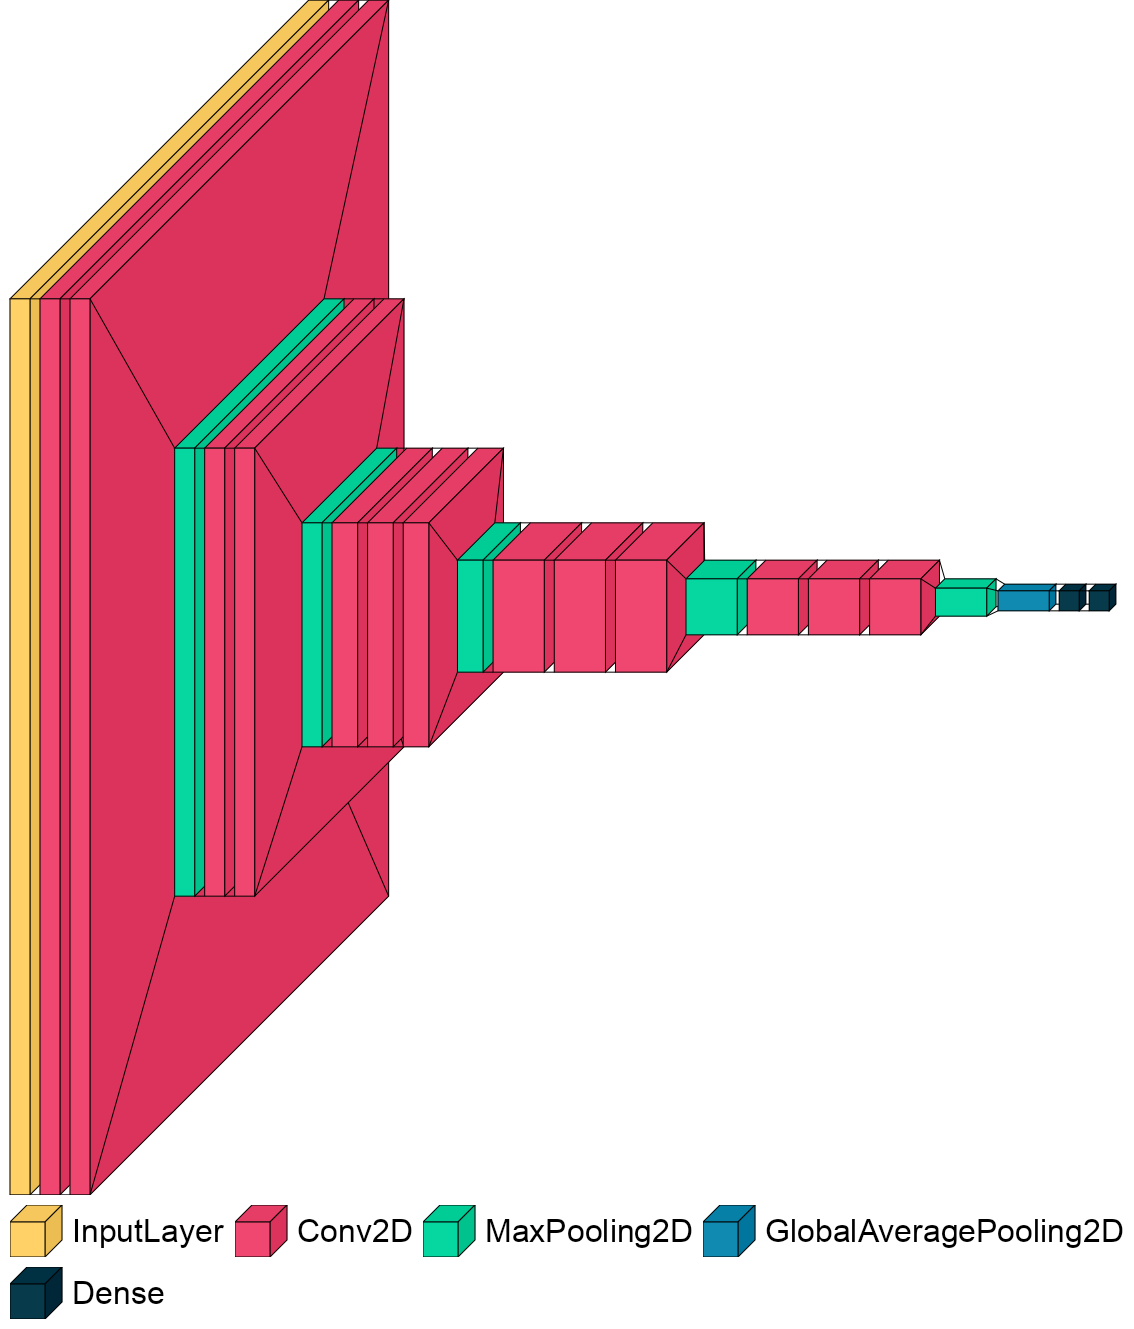

In [42]:
font = ImageFont.truetype("Arial.ttf", 32)
visualkeras.layered_view(VGG_model, legend=True, font=font, max_z=400)

In [43]:
name = './unet_model.h5'
checkp = [EarlyStopping(patience=2),
              ModelCheckpoint(name, monitor = 'accuracy', save_best_only = True, verbose = 1)]
start_time = time.time()# your code here#
VGG_history = VGG_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [checkp]
)
VGG_time =time.time() - start_time # Your code here #
VGG_model_parameters = VGG_model.count_params() # Your code here #

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


255/255 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6644
Epoch 1: accuracy improved from -inf to 0.66435, saving model to ./unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 713s 3s/step - loss: 0.0000e+00 - accuracy: 0.6644 - val_loss: 0.0000e+00 - val_accuracy: 0.6756
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6644
Epoch 2: accuracy did not improve from 0.66435
255/255 [==============================] - 610s 2s/step - loss: 0.0000e+00 - accuracy: 0.6644 - val_loss: 0.0000e+00 - val_accuracy: 0.6756
Epoch 3/10
255/255 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6644
Epoch 3: accuracy did not improve from 0.66435
255/255 [==============================] - 621s 2s/step - loss: 0.0000e+00 - accuracy: 0.6644 - val_loss: 0.0000e+00 - val_accuracy: 0.6756


In [44]:
VGG_train_acc = VGG_history.history['accuracy'][-1]
VGG_val_acc = VGG_history.history['val_accuracy'][-1]
VGG_train_loss = VGG_history.history['loss'][-1]
VGG_val_loss = VGG_history.history['val_loss'][-1]

now we want to plot:

*   Training Loss
*   Validation Loss
*   Training Accuracy
*   Validation Accuracy
*   Confusion Matrix





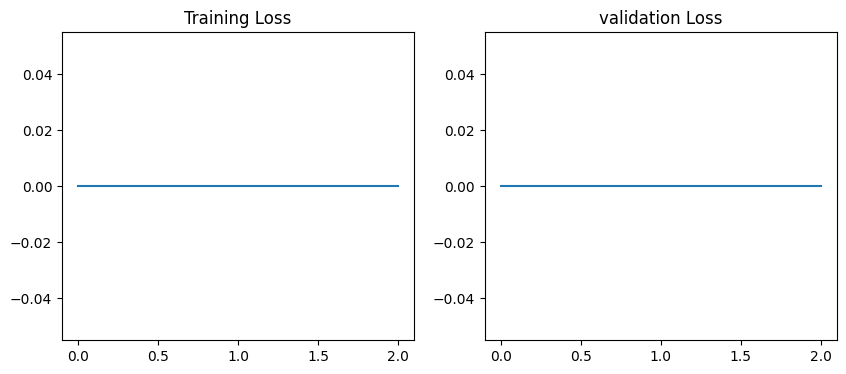

In [45]:
loss_plot(VGG_history)

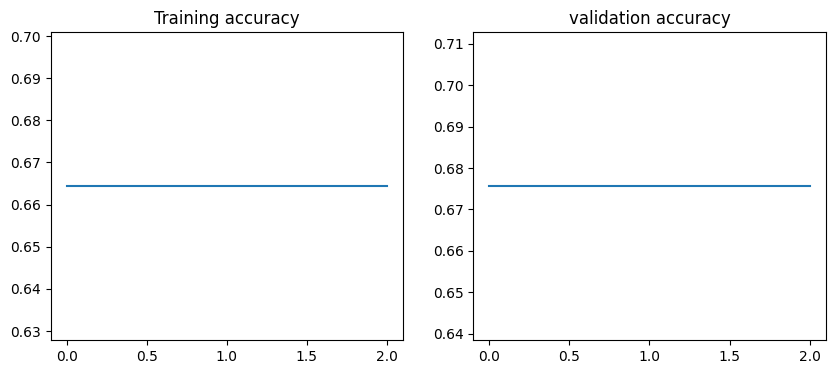

In [46]:
acc_plot(VGG_history)

In [47]:
cm_plot(VGG_model)

AxisError: ignored

In [48]:
visualizer(val_generator, VGG_model, (20,10), (2,4))

2/2 [==============================] - 0s 163ms/step


AxisError: ignored

## Resnet

ResNet, short for Residual Network, is a deep convolutional neural network architecture that was introduced by researchers Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their 2015 paper titled "Deep Residual Learning for Image Recognition." It won the 2016 ImageNet competition, demonstrating its effectiveness in image classification tasks.

The key innovation in ResNet is the use of residual blocks, which address the vanishing gradient problem that often occurs in very deep neural networks. The vanishing gradient problem can make it challenging for traditional deep networks to learn effectively as the gradients become extremely small, hindering the training process.

In a residual block, instead of trying to learn the mapping directly, the network learns residual functions. The output of a layer is added to the input, creating a shortcut connection (or "skip connection"). This enables the network to learn the difference or residual between the input and the desired output, making it easier for the network to learn identity mappings. The residual blocks allow the model to efficiently train very deep networks by mitigating the vanishing gradient issue.

The architecture of ResNet consists of multiple residual blocks stacked on top of each other, forming a deep neural network. Different versions of ResNet, such as ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, are based on the number and structure of these residual blocks. We use ResNet-50 in this project.

ResNet has had a significant impact on the field of computer vision and deep learning, especially in image recognition tasks. Its concepts of residual learning and skip connections have been incorporated and adapted in various architectures to improve training and performance in deep neural networks.

In [49]:
resnet50 = keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(size,size,3))
resnet_model = define_model(conv_model)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

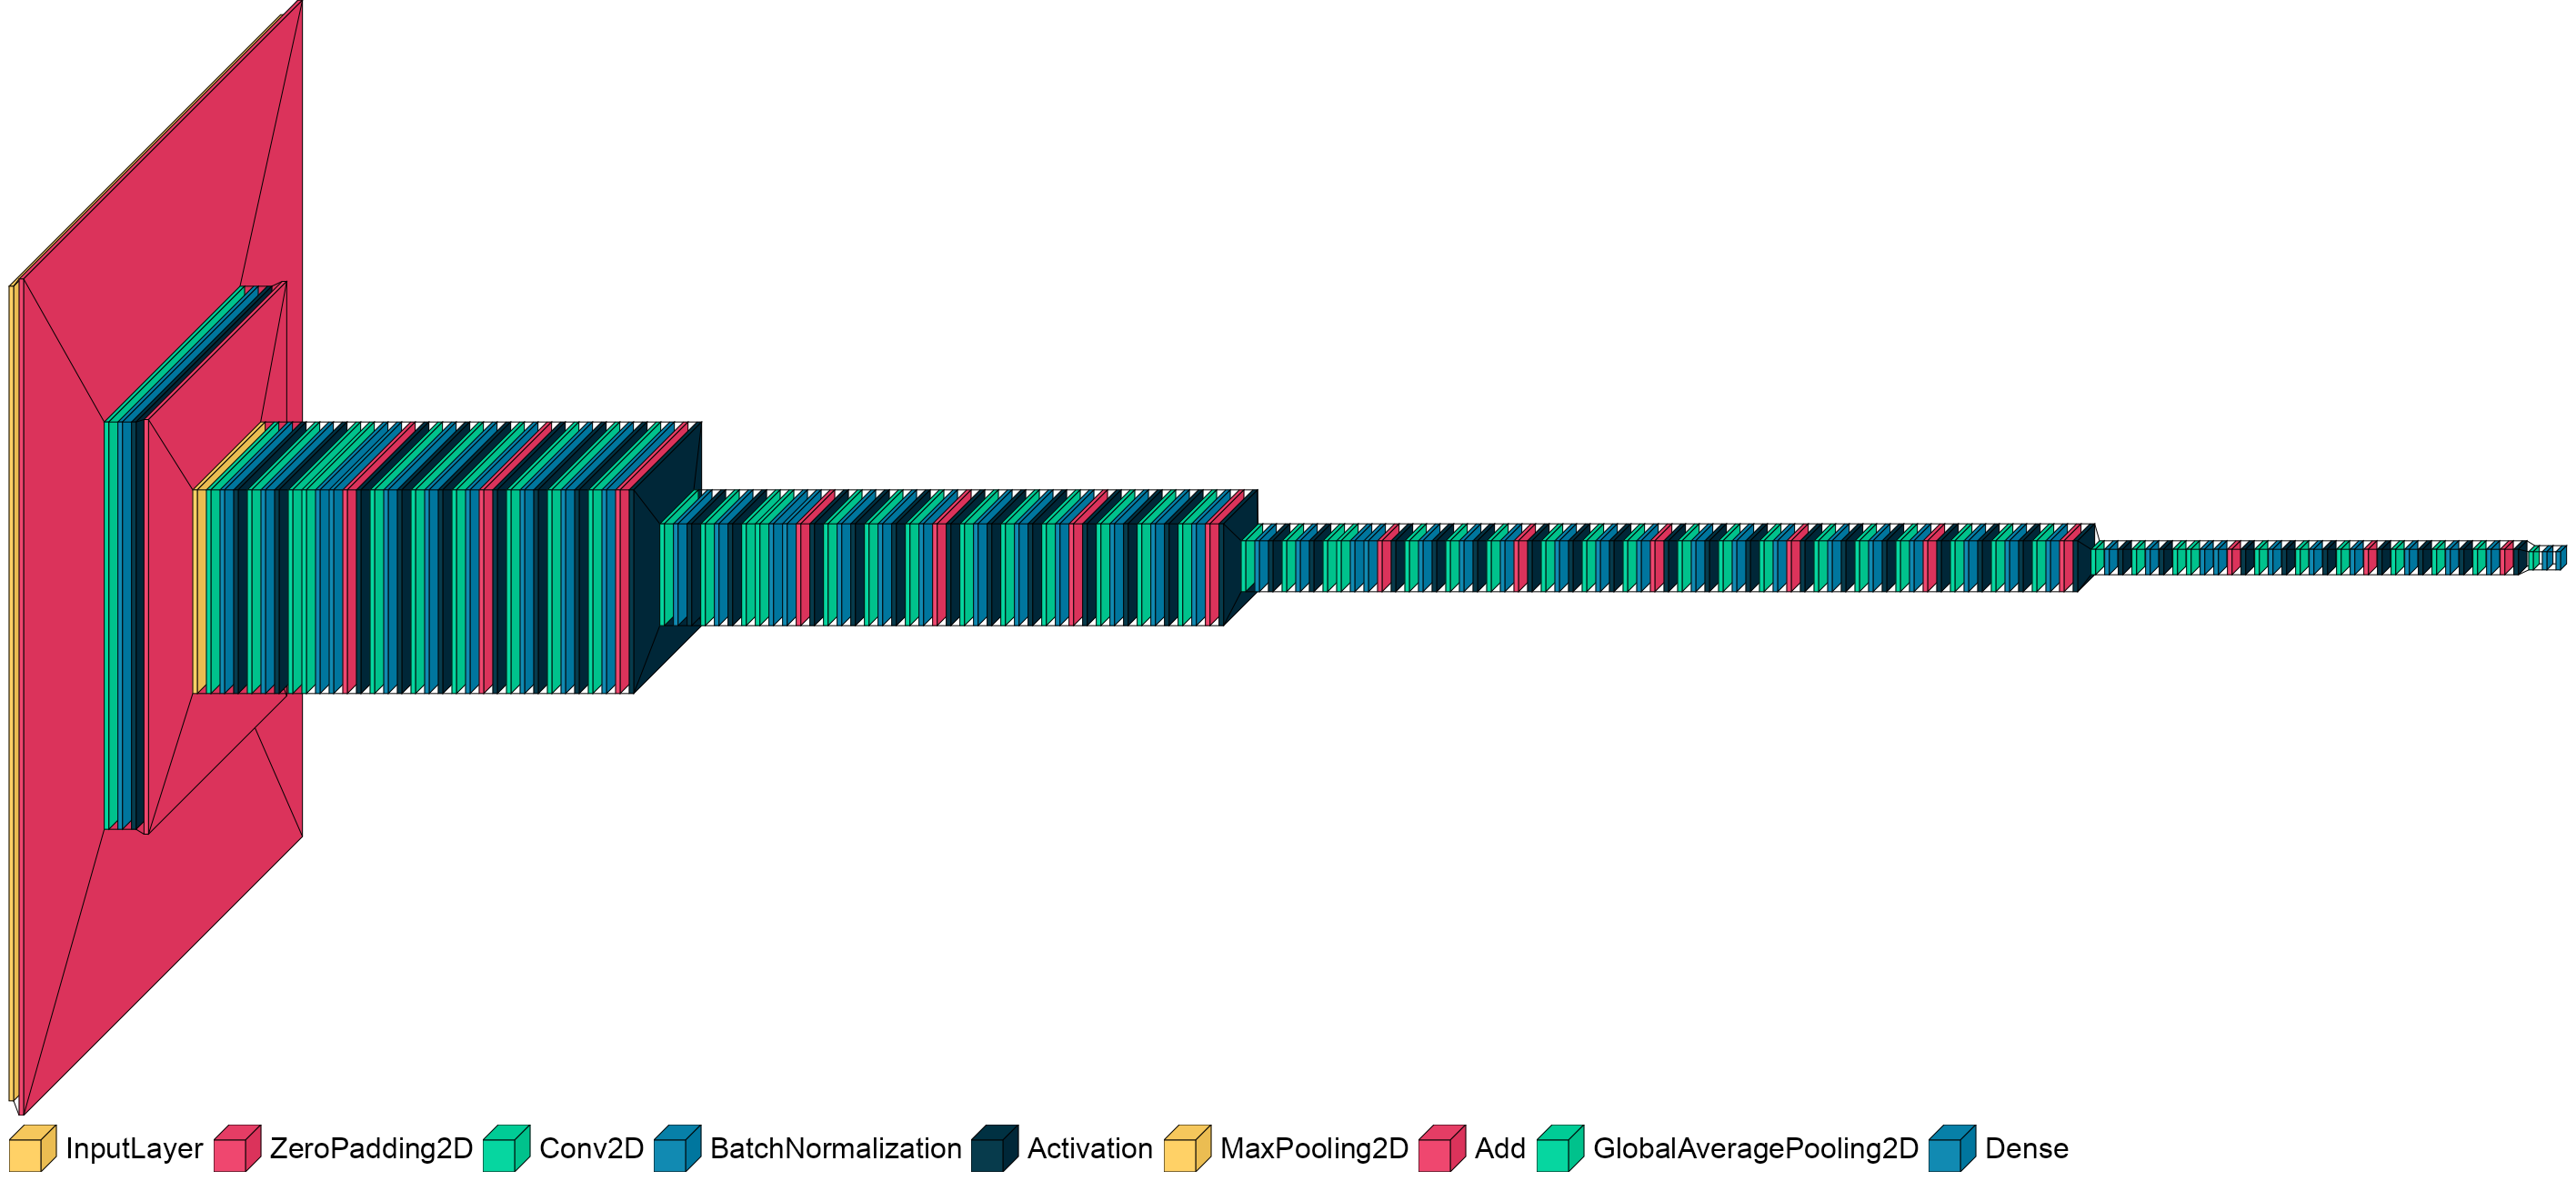

In [50]:
font = ImageFont.truetype("Arial.ttf", 32)
visualkeras.layered_view(resnet_model, legend=True, font=font, max_z=5)

In [51]:
name = './unet_model.h6'
checkp = [EarlyStopping(patience=2),
              ModelCheckpoint(name, monitor = 'accuracy', save_best_only = True, verbose = 1)]
start_time = time.time()# Your code here #
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [checkp]
)
resnet_time = time.time() - start_time# Your code here #
resnet_model_parameters = resnet_model.count_params() # Your code here #

Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6644
Epoch 1: accuracy improved from -inf to 0.66435, saving model to ./unet_model.h6
255/255 [==============================] - 671s 3s/step - loss: 0.0000e+00 - accuracy: 0.6644 - val_loss: 0.0000e+00 - val_accuracy: 0.6756
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6644
Epoch 2: accuracy did not improve from 0.66435
255/255 [==============================] - 652s 3s/step - loss: 0.0000e+00 - accuracy: 0.6644 - val_loss: 0.0000e+00 - val_accuracy: 0.6756
Epoch 3/10
255/255 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.6644
Epoch 3: accuracy did not improve from 0.66435
255/255 [==============================] - 638s 3s/step - loss: 0.0000e+00 - accuracy: 0.6644 - val_loss: 0.0000e+00 - val_accuracy: 0.6756


In [52]:
resnet_train_acc = resnet_history.history['accuracy'][-1]
resnet_val_acc = resnet_history.history['val_accuracy'][-1]
resnet_train_loss = resnet_history.history['loss'][-1]
resnet_val_loss = resnet_history.history['val_loss'][-1]

now we want to plot:

*   Training Loss
*   Validation Loss
*   Training Accuracy
*   Validation Accuracy
*   Confusion Matrix


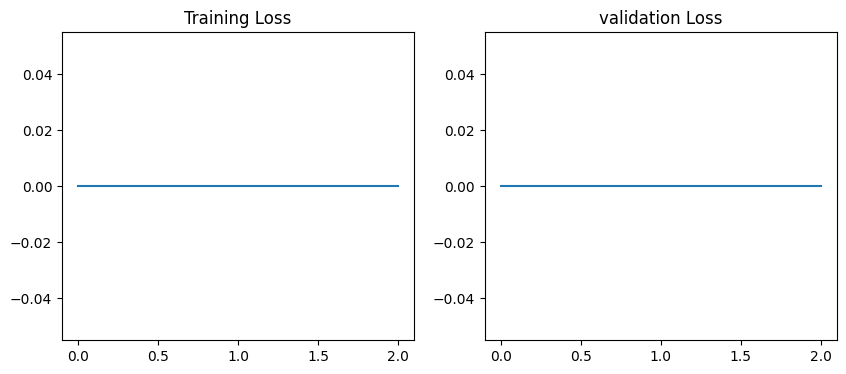

In [53]:
loss_plot(resnet_history)

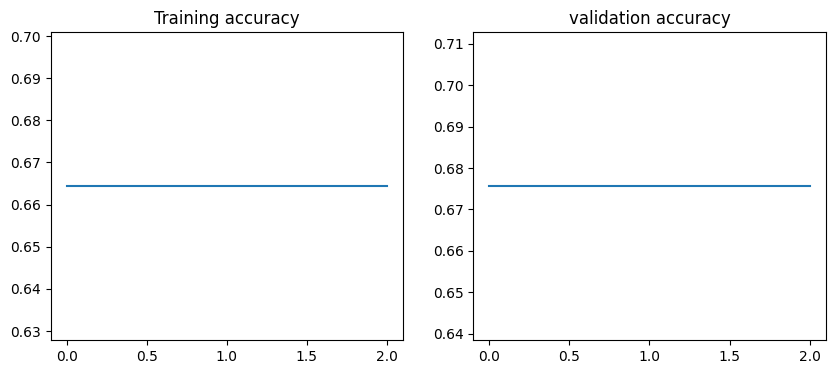

In [54]:
acc_plot(resnet_history)

In [65]:
cm_plot(resnet_model)

TypeError: ignored

2/2 [==============================] - 0s 124ms/step


IndexError: ignored

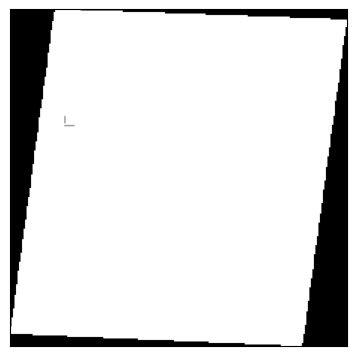

In [64]:
visualizer(val_generator, resnet_model, (20,10), (2,4))

# Conclusion

At the end, we compare the results in the form of a table

In [57]:
myTable = PrettyTable(["model", "number of train data", "number of test data", "train accuracy", "test accuracy", "time", "parametes"])

# Add rows
# Your code here #
myTable.add_row(["VGG16", train_size, validation_size, VGG_train_acc, VGG_val_acc, VGG_time, VGG_model_parameters])
myTable.add_row(["ResNet50", train_size, validation_size, resnet_train_acc, resnet_val_acc, resnet_time, resnet_model_parameters])

print(myTable)

+----------+----------------------+---------------------+--------------------+--------------------+--------------------+-----------+
|  model   | number of train data | number of test data |   train accuracy   |   test accuracy    |        time        | parametes |
+----------+----------------------+---------------------+--------------------+--------------------+--------------------+-----------+
|  VGG16   |        16261         |         4066        | 0.6643502712249756 | 0.6756025552749634 | 1946.5308074951172 |  14780481 |
| ResNet50 |        16261         |         4066        | 0.6643502712249756 | 0.6756025552749634 | 1978.5221874713898 |  23850113 |
+----------+----------------------+---------------------+--------------------+--------------------+--------------------+-----------+
